In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import date, datetime as dt
import numpy as np
from tqdm import tqdm
import altair as alt
from vega_datasets import data
import re
import math
sns.set(font_scale = 1.2)
sns.set_style("ticks")

In [ ]:
final_df = pd.read_pickle('./models/OCR_Speller/final_dataset_social.pkl')

In [ ]:
df_likes = final_df[['id_community', 'id_post', 'date_posted', 'count_likes']]
del final_df

In [ ]:
df_likes['id_community'].unique()

In [ ]:
print(*list(map(lambda x: f'https://vk.com/wall{x}', df_likes['id_community'].unique())), sep='\n')

In [ ]:
communities = dict(zip([-95355317, -57846937, -158490202, -131489096,  -91050183, -28468381,  -25679656], ['Двач', 'MDK', 'Мемы про школу', 'Мемы про машинное обучение', 'Леонардо Дайвинчик', 'Юмор категории Б', 'Тонкий юмор']))

In [ ]:
df_likes.head()

In [ ]:
q_likes = dict()
for c in df_likes['id_community'].unique():
    g_df1 = my_df.set_index(['id_community', 'date_posted']).xs(key=c, axis=0, level='id_community').groupby(by=[pd.Grouper(freq='M')])
    q_likes = pd.DataFrame(g_df1['count_likes'].quantile([0.05, 0.25, 0.75, 0.95])).reset_index()\
          .rename(columns={'level_1':'q'}).pivot(index='date_posted', columns='q', values='count_likes')\
          .rename(columns=lambda x: 'q' + str(x))

In [ ]:
def make_plots_popular(my_df, owner_id_comm):

    f = plt.figure(figsize=(15, 7))
    plt.fill_between(q_likes.index, q_likes['q0.05'], q_likes['q0.25'], alpha=0.5, 
                     facecolor='firebrick', label='низкая (L<Q1)')
    plt.fill_between(q_likes.index, q_likes['q0.25'], q_likes['q0.75'], alpha=0.5,
                     facecolor='grey', label='средняя (Q1<L<Q3)')
    plt.fill_between(q_likes.index, q_likes['q0.75'], q_likes['q0.95'], alpha=0.5,
                     facecolor='forestgreen', label='высокая (L>Q3)')
    plt.plot(q_likes['q0.25'], c='firebrick', lw=0.8)
    plt.plot(q_likes['q0.75'], c='forestgreen', lw=0.8)
    plt.title('Сообщество: ' + communities[owner_id_comm])
    plt.ylabel('Количество лайков')
    plt.legend()
    return plt

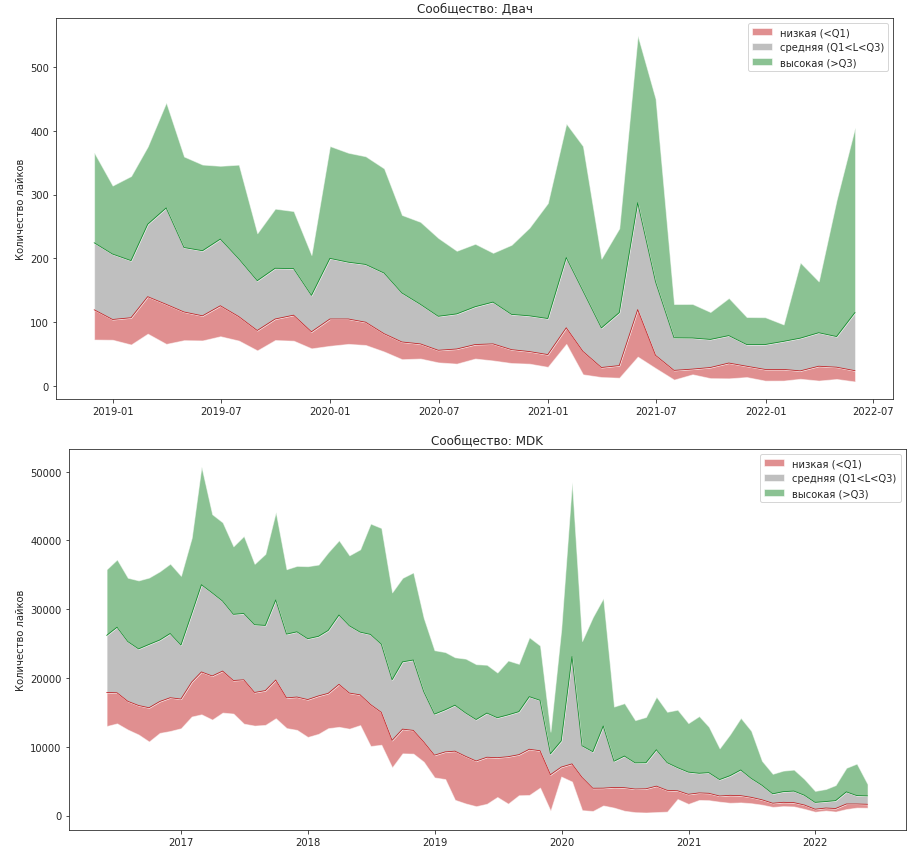

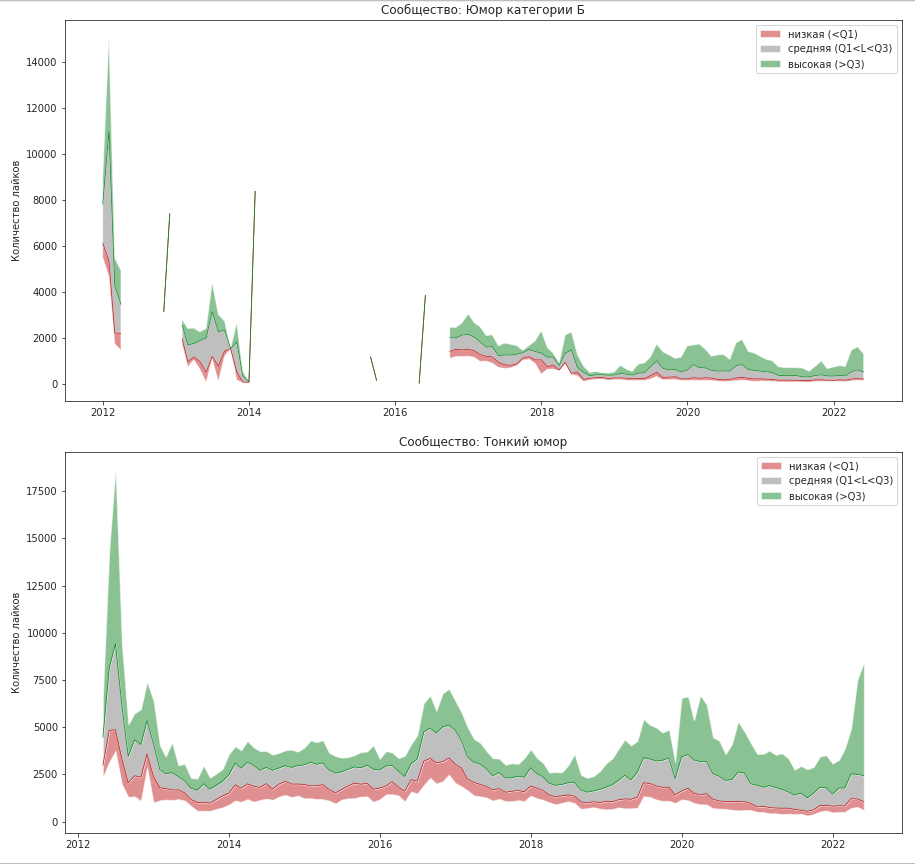

In [ ]:
for own_id in final_df['id_community'].astype(str).unique():
    make_plots_popular(final_df, int(own_id))

In [ ]:
with open('models/OCR_Speller/russian-words-master/russian.utf-8', 'r') as f:
    words = set(f.read().splitlines())

In [ ]:
re.sub(r'[^А-Яа-яЁё\- ]', '', 'Компания Гугл прислала подарки ребенку из Индонезии, которого назвали Гугл Соот]е Я через пару лет: нкацвЁмккшу ДЕвЦККУ щекнккир дквкй лучШЕ Шкукмекккякк мплпдёжнийю')

In [ ]:
def perc_unknown_words(s, vocab):
    words = s.lower().split()
    res =  sum(1 for w in words if w not in vocab ) / len(words) if len(words) > 0 else 0

    return res

In [ ]:
perc_res_text = np.array([perc_unknown_words(re.sub(r'[^А-Яа-яЁё\- ]', '', i), words) for i in res])
sns.displot(perc_res_text, kind='kde')

In [ ]:
for index, row in tqdm(final_df.iterrows()):
    if (row['spell_text_ocr_image'] != ''):
        final_df.at[index, 'perc_unk_words'] = perc_unknown_words(row['spell_text_ocr_image'], words)
    if (row['spell_text_with_re'] != ''):
        final_df.at[index, 'perc_unk_words_re'] = perc_unknown_words(row['spell_text_with_re'], words)
        
#     prob_text = row['spell_text_with_re']
#     df_test.at[index, 'exist_swear'] = predict([f'predict() {prob_text}'])[0]

#         df_test.at[index,'spell_text_ocr_image'] = spelling_text[0].lower()

In [ ]:
sns.displot(final_df['perc_unk_words'].values, kind='kde')

In [ ]:
sns.displot(final_df['perc_unk_words_re'].values, kind='kde')

In [ ]:
final_df['dayofweek'] = final_df['date'].dt.dayofweek
final_df['weekend'] = final_df['dayofweek'] > 4
for f in 'count_likes', 'count_views', 'count_comments','count_reposts':
    final_df[f"log_{f}"] = np.log10(final_df[f]+1)

In [ ]:
final_df.to_pickle('./dataset_social_final_finish.pkl')

In [ ]:
final_df = pd.read_pickle('./dataset_social_final_finish.pkl')

In [ ]:
final_df['id_community'].values

In [ ]:
final_df['year'].groupby([final_df.type_post, final_df.year]).agg('count')

In [ ]:
communities = final_df['id_community'].unique()
f, ax = plt.subplots(1, len(communities), figsize=(20, 8))
for i, c in enumerate(communities):
    final_df.query('id_community == @c')['type_post'].value_counts().plot(
        kind='pie', ax=ax[i], title=c, legend=False, autopct='%1.1f%%')

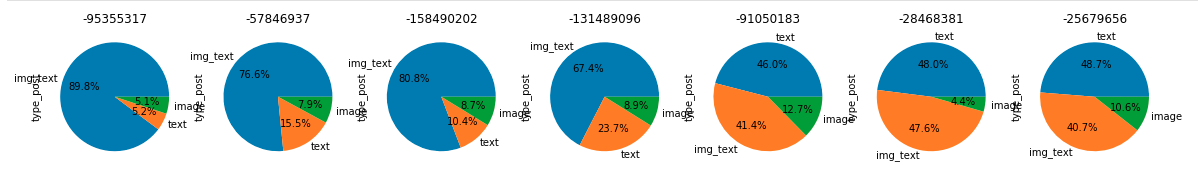

In [ ]:
cols = 3
rows = math.ceil(len(final_df) / cols)

communities = final_df['id_community'].unique()
f, ax = plt.subplots(rows, cols, figsize=(20, 8))
for i, c in enumerate(communities):
    final_df.query('id_community == @c')['type_post'].value_counts().plot(
        kind='pie', ax=ax[i % rows][i // rows], title=c, legend=False, autopct='%1.1f%%')

In [ ]:
alt.data_transformers.disable_max_rows()

In [ ]:
alt.Chart(final_df[:130000]).mark_area().encode(
    x=alt.X('date:T',
        timeUnit='yearmonth',
        axis=alt.Axis(format='%Y', labelAngle=0, title='year')
    ),
    y=alt.Y("count()", stack="normalize", axis=alt.Axis(format='%')),
    color="type_post:N",
    facet=alt.Facet('id_community:O', columns=4)
).properties(width=250, height=200)

In [ ]:
final_df['year'].groupby([final_df.type_post, final_df.year]).agg('count')

In [ ]:
final_df.columns

In [ ]:
final_df['id_community'].astype(str).unique()

In [ ]:
df_test = final_df.loc[final_df['id_community'].isin(['-25679656'])]

In [ ]:
df_test = final_df.set_index(['id_community', 'date_posted'])

In [ ]:
df1 = df_test.xs(key=-25679656, axis=0, level='id_community')

## Матерные слова

In [ ]:
import spacy
from spacy.lang.ru.examples import sentences 

nlp = spacy.load("ru_core_news_sm")
doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)

In [ ]:
! python -m spacy validate

In [ ]:
import profanity_filter
import spacy
from spacy.tokens import Doc
# from spacy_transformers import TransformerData
# from thinc.api import set_gpu_allocator, require_gpu
Doc.has_extension("is_profane")

In [ ]:
if not Doc.has_extension("text_id"):
    Doc.set_extension("text_id", default=None)

text_tuples = [
    ("This is the first text.", {"text_id": "text1"}),
    ("This is the second text.", {"text_id": "text2"})
]

nlp = spacy.load("en_core_web_sm")
doc_tuples = nlp.pipe(text_tuples, as_tuples=True)

docs = []
for doc, context in doc_tuples:
    doc._.text_id = context["text_id"]
    docs.append(doc)

for doc in docs:
    print(f"{doc._.text_id}: {doc.text}")

In [ ]:
nlp = spacy.load('ru_core_news_sm')
profanity_filter = ProfanityFilter(nlps={'ru': nlp})  # reuse spacy Language (optional)
# nlp.add_pipe(profanity_filter.spacy_component, last=True)

doc = nlp('')
for token in doc:
#     print(token.text, token.pos_, token.lemma_)
    token._.is_profane